### Problem statement:
To understand if there is an issue with Waterco' customers paying a given invoice late, and what factors influence it

### Areas to cover:
What are the key findings from the dataset that are important and relevant to the clients problem?
How did you arrive at these findings?

### The approaches of the project are in the following steps:
1. Data cleaning and pre-processing
2. Statistical analysis and feature selection
3. Building supervised learning models with training data
4. Test and evaluate the performance of classification models

In [1]:
#Import required packages
import pandas as pd
from pandas import DataFrame
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.misc
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, precision_recall_fscore_support
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.utils import resample
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import scikitplot as skplt
from sklearn.feature_extraction import FeatureHasher
%matplotlib inline

### Waterco invoice dataset:
Name: waterloo_missing_payment_data_LC.csv

#### Target and features:
* Target – Billing_Issues_1month: This is the primary column to predict, this indicates if the account has raised distress with the invoice provided
* Invoice_Count: Count of invoices sent to this account
* Qtr: Quarter the invoice was sent in 
* Year: Year the invoice was sent in 
* Billing_Method: Method used to communicate the invoice 
* Payment_Method: Method used to pay for the invoice 
* Risk_Factor: Predetermined risk factor of the account 
* Hardship_Notice: If the account is currently placed on hardship (unable to pay a bill, etc) 
* Payment_Agreement: If the account has an agreement for payment of previous outstanding invoices
* Concession_Agreement: If the account has any agreed concession for payment of invoices 
* High_Usage_Indicator: If the account has been determined to be a high-water user
* Invoice_Notice_Sent: Invoice sent to the account 
* Final_Notice_Sent: Final invoice reminder sent to the account
* Payment_Issue_Notice: Notice issue to the account if there are payment issues with reoccurring payment plans
* Requested_Additional_Payment_Time: If the account has requested additional time to pay a bill 
* Gov_Grant_Enrolled: If the are enrolled in the Welfare or Temporary Assistance for Needy Families (TANF) provided by the USA Government
* Prior_Hardship_Notice: If the account has been placed on hardship (unable to pay a bill, etc) previously
* Complaint_Count: Count of complaints made by the account to the service team
* Customer_Contact_Count: Count of the amount of contact between account and service team
* Property_Type: Type of property 
* Property_Suburb: Suburb of property location
* Property_County: County of property location
* Gov_Housing: If the are enrolled in the Welfare or Temporary Assistance for Needy Families (TANF) provided by the USA Government in Government housing 
* Qtr_Rain_MM: Measurement of rainwater for County quarterly 


#### Categorical features:
* Yes and No:
    * Billing_Issues_1month
    * Hardship_Notice
    * Payment_Agreement
    * Concession_Agreement
    * High_Usage_Indicator
    * Invoice_Notice_Sent
    * Final_Notice_Sent
    * Payment_Issue_Notice
    * Requested_Additional_Payment_Time
    * Gov_Grant_Enrolled
    * Prior_Hardship_Notice
    * Gov_Housing
* Others:
    * Billing_Method (Mail, Email, BPAY View)
    * Payment_Method (Payment_Method 1-20)
    * Risk_Factor (Low Risk, Excluded, Medium Risk, High Risk, Risk Not Calculated)
    * Property_Type (Dwelling, Apartment, Unit)
    * Property_Suburb (Property_Suburb 1-248)
    * Property_County (Property_County 1-15 & 17)

#### Numerical features (in reality nominal categorical features):
* Invoice_Count (2-276)
* Qtr (1, 2, 3)
* Complaint_Count (0, 1, 2, 3, 4)
* Customer_Contact_Count (1-76)
* Qtr_Rain_MM (24 values from 0 to 277.4)

### Data Exploration & Cleaning

In [2]:
#Read both the data sets
pd.set_option('display.max_columns', None)
waterco_data = pd.read_csv("Data/waterco_missed_payments_data_LC.csv")
waterco_data.head()

,Billing_Issues_1month,Invoice_Count,Qtr,Year,Billing_Method,Payment_Method,Risk_Factor,Hardship_Notice,Payment_Agreement,Concession_Agreement,High_Usage_Indicator,Invoice_Notice_Sent,Final_Notice_Sent,Payment_Issue_Notice,Requested_Additional_Payment_Time,Gov_Grant_Enrolled,Prior_Hardship_Notice,Complaint_Count,Customer_Contact_Count,Property_Type,Property_Suburb,Property_County,Gov_Housing,Qtr_Rain_MM
0,No,50,1,2017,Mail,Payment_Method 1,Low Risk,No,Yes,No,No,Yes,Yes,Yes,Yes,No,No,NaN,8,Dwelling,Property_Suburb 1,Property_County 1,No,152.2
1,No,51,2,2017,Mail,Payment_Method 1,Low Risk,No,Yes,No,No,Yes,Yes,Yes,Yes,No,No,NaN,8,Dwelling,Property_Suburb 1,Property_County 1,No,172.1
2,No,38,1,2017,Mail,Payment_Method 2,Low Risk,No,No,No,No,Yes,Yes,No,No,No,No,NaN,1,Dwelling,Property_Suburb 3,Property_County 3,No,132.8
3,No,34,1,2017,Mail,Payment_Method 2,Low Risk,No,No,Yes,No,Yes,No,No,Yes,No,No,NaN,3,Unit,Property_Suburb 4,Property_County 1,No,152.2
4,Yes,33,1,2017,Email,Payment_Method 4,Low Risk,No,No,No,No,Yes,Yes,No,Yes,No,No,NaN,4,Unit,Property_Suburb 5,Property_County 4,No,98.2


In [3]:
waterco_data.shape

(313962, 24)

In [4]:
waterco_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313962 entries, 0 to 313961
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Billing_Issues_1month              313962 non-null  object 
 1   Invoice_Count                      313962 non-null  int64  
 2   Qtr                                313962 non-null  int64  
 3   Year                               313962 non-null  int64  
 4   Billing_Method                     313962 non-null  object 
 5   Payment_Method                     313962 non-null  object 
 6   Risk_Factor                        313962 non-null  object 
 7   Hardship_Notice                    313962 non-null  object 
 8   Payment_Agreement                  313962 non-null  object 
 9   Concession_Agreement               313962 non-null  object 
 10  High_Usage_Indicator               313962 non-null  object 
 11  Invoice_Notice_Sent                3139

Summary: The dataset has a lot of categorical columns. Complain_Count is the only colum with missing values.

#### Dropping constant features & duplicate rows

In [5]:
waterco_data = waterco_data.loc[:, waterco_data.nunique() != 1]

In [6]:
waterco_data = waterco_data.drop_duplicates().reset_index()
waterco_data = waterco_data.drop("index",1)
waterco_data.shape

(288187, 23)

Summary: Since the value of Year is only 2017, this column is removed (constant feature). 
The non-null+null count is reduced to 288187 after removing row duplicates for all features.

### Feature Transformation

#### Missing values treatment:
Looking at the data, the only column with missing values is the 'Complaint_Count' column, 
the missing values represents 0.

In [7]:
# replace missing values with 0
waterco_data['Complaint_Count'].loc[waterco_data['Complaint_Count'].isna()] = 0
# converting the type from float to int
waterco_data['Complaint_Count'] = waterco_data['Complaint_Count'].astype(int)
#count values in Complaint_Count column
waterco_data['Complaint_Count'].value_counts()

/Users/atieh/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


0    286739
1      1302
2       116
3        29
4         1
Name: Complaint_Count, dtype: int64

#### Cardinality analysis and Binning:

Text(0.5, 1.0, 'Cardinality')

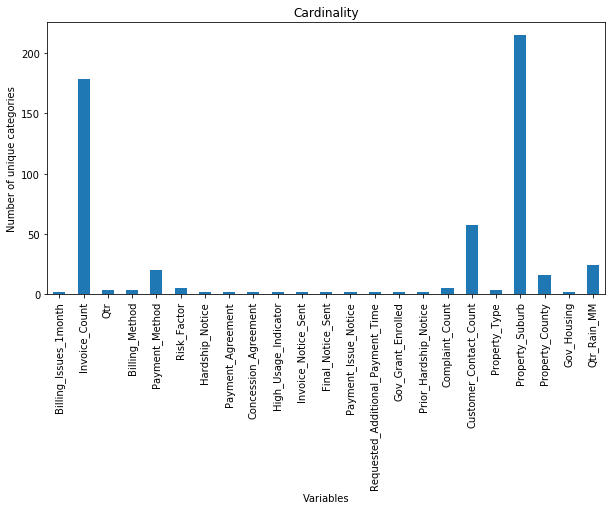

In [8]:
# waterco_data.nunique()
waterco_data.nunique().plot.bar(figsize=(10,5))
plt.ylabel('Number of unique categories')
plt.xlabel('Variables')
plt.title('Cardinality')

In [9]:
waterco_data_fh = waterco_data

In [10]:
waterco_data_fh = waterco_data_fh.astype(str)

In [11]:
waterco_data_fh.shape

(288187, 23)

In [12]:
columns = ['Property_Suburb', 'Customer_Contact_Count', 'Invoice_Count', 'Property_County', 'Qtr_Rain_MM', 
           'Payment_Method']

fh = FeatureHasher(n_features=6, input_type='string')

hashed_features_ps = fh.fit_transform(waterco_data_fh[columns[0]]).toarray()
hashed_ps_data = pd.DataFrame(hashed_features_ps)
hashed_ps_data.rename(columns={0:'ps_0', 1:'ps_1', 2:'ps_2', 3:'ps_3', 4:'ps_4', 5:'ps_5'}, inplace=True)
hashed_features_ccc = fh.fit_transform(waterco_data_fh[columns[1]]).toarray()
hashed_ccc_data = pd.DataFrame(hashed_features_ccc)
hashed_ccc_data.rename(columns={0:'ccc_0', 1:'ccc_1', 2:'ccc_2', 3:'ccc_3', 4:'ccc_4', 5:'ccc_5'}, inplace=True)
hashed_features_ic = fh.fit_transform(waterco_data_fh[columns[2]]).toarray()
hashed_ic_data = pd.DataFrame(hashed_features_ic)
hashed_ic_data.rename(columns={0:'ic_0', 1:'ic_1', 2:'ic_2', 3:'ic_3', 4:'ic_4', 5:'ic_5'}, inplace=True)
hashed_features_pc = fh.fit_transform(waterco_data_fh[columns[3]]).toarray()
hashed_pc_data = pd.DataFrame(hashed_features_pc)
hashed_pc_data.rename(columns={0:'pc_0', 1:'pc_1', 2:'pc_2', 3:'pc_3', 4:'pc_4', 5:'pc_5'}, inplace=True)
hashed_features_qrm = fh.fit_transform(waterco_data_fh[columns[4]]).toarray()
hashed_qrm_data = pd.DataFrame(hashed_features_qrm)
hashed_qrm_data.rename(columns={0:'qrm_0', 1:'qrm_1', 2:'qrm_2', 3:'qrm_3', 4:'qrm_4', 5:'qrm_5'}, inplace=True)
hashed_features_pm = fh.fit_transform(waterco_data_fh[columns[5]]).toarray()
hashed_pm_data = pd.DataFrame(hashed_features_pm)
hashed_pm_data.rename(columns={0:'pm_0', 1:'pm_1', 2:'pm_2', 3:'pm_3', 4:'pm_4', 5:'pm_5'}, inplace=True)


pdList = [hashed_ps_data, hashed_ccc_data, hashed_ic_data, hashed_pc_data, hashed_qrm_data, hashed_pm_data]  # List of your dataframes
hashed_data = pd.concat(pdList, axis=1)



In [13]:
waterco_data_hashed = pd.concat([waterco_data_fh.reindex(hashed_data.index), hashed_data], axis=1)

In [14]:
waterco_data_hashed = waterco_data_hashed.drop(['Property_Suburb', 'Customer_Contact_Count', 'Invoice_Count', 'Property_County', 'Qtr_Rain_MM', 
           'Payment_Method'],1)

In [15]:
waterco_data_hashed.tail()

,Billing_Issues_1month,Qtr,Billing_Method,Risk_Factor,Hardship_Notice,Payment_Agreement,Concession_Agreement,High_Usage_Indicator,Invoice_Notice_Sent,Final_Notice_Sent,Payment_Issue_Notice,Requested_Additional_Payment_Time,Gov_Grant_Enrolled,Prior_Hardship_Notice,Complaint_Count,Property_Type,Gov_Housing,ps_0,ps_1,ps_2,ps_3,ps_4,ps_5,ccc_0,ccc_1,ccc_2,ccc_3,ccc_4,ccc_5,ic_0,ic_1,ic_2,ic_3,ic_4,ic_5,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,qrm_0,qrm_1,qrm_2,qrm_3,qrm_4,qrm_5,pm_0,pm_1,pm_2,pm_3,pm_4,pm_5
288182,Yes,1,Mail,Low Risk,No,No,No,Yes,Yes,Yes,No,Yes,No,No,0,Dwelling,Yes,-1.0,5.0,1.0,-1.0,3.0,-3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,1.0,-2.0,5.0,2.0,-2.0,3.0,-1.0,0.0,-1.0,0.0,1.0,0.0,-1.0,0.0,3.0,2.0,-1.0,3.0,-2.0
288183,No,2,Mail,Low Risk,No,No,No,No,Yes,No,No,Yes,No,No,0,Dwelling,No,-2.0,3.0,2.0,0.0,3.0,-3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,-1.0,5.0,1.0,-2.0,3.0,-1.0,0.0,-1.0,-2.0,1.0,0.0,-1.0,-1.0,4.0,3.0,-1.0,3.0,-2.0
288184,No,1,Mail,Low Risk,No,No,Yes,No,No,No,No,No,No,No,0,Dwelling,No,-1.0,5.0,1.0,-1.0,3.0,-3.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,-2.0,5.0,2.0,-2.0,3.0,-1.0,0.0,-2.0,0.0,0.0,0.0,-1.0,-1.0,4.0,2.0,0.0,3.0,-2.0
288185,No,2,Mail,Low Risk,No,No,No,No,No,Yes,No,Yes,No,No,0,Apartment,No,-2.0,4.0,1.0,-1.0,3.0,-3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,-1.0,5.0,1.0,-2.0,3.0,-1.0,0.0,-1.0,-2.0,1.0,0.0,-1.0,-1.0,4.0,2.0,0.0,3.0,-2.0
288186,No,2,Email,Low Risk,No,No,No,No,No,No,No,No,No,No,0,Apartment,No,-2.0,4.0,1.0,0.0,3.0,-2.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-2.0,3.0,1.0,-2.0,3.0,-1.0,0.0,-1.0,-2.0,1.0,0.0,-1.0,-1.0,3.0,2.0,-1.0,3.0,-2.0


#### categorical to numerical and creation of dummy variables:
Many of the categorical features only have Yes/No and so can be easily converted to 1/0 respectively.
Similarly, Billing_Method, Property_Type, and Risk_Factor have only 3 to 5 options that can be converted to 1-3, 1-5
respectively.

In [16]:
waterco_data['Billing_Issues_1month'] = np.where(waterco_data['Billing_Issues_1month'] =='Yes',1,0)
waterco_data['Hardship_Notice'] = np.where(waterco_data['Hardship_Notice'] =='Yes',1,0)
waterco_data['Payment_Agreement'] = np.where(waterco_data['Payment_Agreement'] =='Yes',1,0)
waterco_data['Concession_Agreement'] = np.where(waterco_data['Concession_Agreement'] =='Yes',1,0)
waterco_data['High_Usage_Indicator'] = np.where(waterco_data['High_Usage_Indicator'] =='Yes',1,0)
waterco_data['Invoice_Notice_Sent'] = np.where(waterco_data['Invoice_Notice_Sent'] =='Yes',1,0)
waterco_data['Final_Notice_Sent'] = np.where(waterco_data['Final_Notice_Sent'] =='Yes',1,0)
waterco_data['Payment_Issue_Notice'] = np.where(waterco_data['Payment_Issue_Notice'] =='Yes',1,0)
waterco_data['Requested_Additional_Payment_Time'] = np.where(
    waterco_data['Requested_Additional_Payment_Time'] =='Yes',1,0)
waterco_data['Gov_Grant_Enrolled'] = np.where(waterco_data['Gov_Grant_Enrolled'] =='Yes',1,0)
waterco_data['Prior_Hardship_Notice'] = np.where(waterco_data['Prior_Hardship_Notice'] =='Yes',1,0)
waterco_data['Gov_Housing'] = np.where(waterco_data['Gov_Housing'] =='Yes',1,0)
# waterco_data['Gov_Housing'] = waterco_data['Gov_Housing'].astype('category').cat.codes

#Others
waterco_data['Payment_Method'] = waterco_data['Payment_Method'].str.split(' ').str[-1].astype('int')
waterco_data['Property_Suburb'] = waterco_data['Property_Suburb'].str.split(' ').str[-1].astype('int')
waterco_data['Property_County'] = waterco_data['Property_County'].str.split(' ').str[-1].astype('int')
waterco_data['Billing_Method'].replace(to_replace=['Mail', 'Email', 'BPAY View'], value=[1, 2, 3], inplace=True)
waterco_data['Property_Type'].replace(to_replace=['Dwelling', 'Apartment', 'Unit'], value=[1, 2, 3], inplace=True)
waterco_data['Risk_Factor'].replace(to_replace=['Low Risk', 'Excluded', 'Medium Risk', 'High Risk', 
                                                'Risk Not Calculated'], value=[1, 2, 3, 4, 5], inplace=True)


In [17]:
#Yes/No items
waterco_data_hashed['Billing_Issues_1month'] = np.where(waterco_data_hashed['Billing_Issues_1month'] =='Yes',1,0)
waterco_data_hashed['Hardship_Notice'] = np.where(waterco_data_hashed['Hardship_Notice'] =='Yes',1,0)
waterco_data_hashed['Payment_Agreement'] = np.where(waterco_data_hashed['Payment_Agreement'] =='Yes',1,0)
waterco_data_hashed['Concession_Agreement'] = np.where(waterco_data_hashed['Concession_Agreement'] =='Yes',1,0)
waterco_data_hashed['High_Usage_Indicator'] = np.where(waterco_data_hashed['High_Usage_Indicator'] =='Yes',1,0)
waterco_data_hashed['Invoice_Notice_Sent'] = np.where(waterco_data_hashed['Invoice_Notice_Sent'] =='Yes',1,0)
waterco_data_hashed['Final_Notice_Sent'] = np.where(waterco_data_hashed['Final_Notice_Sent'] =='Yes',1,0)
waterco_data_hashed['Payment_Issue_Notice'] = np.where(waterco_data_hashed['Payment_Issue_Notice'] =='Yes',1,0)
waterco_data_hashed['Requested_Additional_Payment_Time'] = np.where(
    waterco_data_hashed['Requested_Additional_Payment_Time'] =='Yes',1,0)
waterco_data_hashed['Gov_Grant_Enrolled'] = np.where(waterco_data_hashed['Gov_Grant_Enrolled'] =='Yes',1,0)
waterco_data_hashed['Prior_Hardship_Notice'] = np.where(waterco_data_hashed['Prior_Hardship_Notice'] =='Yes',1,0)
waterco_data_hashed['Gov_Housing'] = np.where(waterco_data_hashed['Gov_Housing'] =='Yes',1,0)
# waterco_data['Gov_Housing'] = waterco_data['Gov_Housing'].astype('category').cat.codes

#Others
waterco_data_hashed['Billing_Method'].replace(to_replace=['Mail', 'Email', 'BPAY View'], value=[1, 2, 3], inplace=True)
waterco_data_hashed['Property_Type'].replace(to_replace=['Dwelling', 'Apartment', 'Unit'], value=[1, 2, 3], inplace=True)
waterco_data_hashed['Risk_Factor'].replace(to_replace=['Low Risk', 'Excluded', 'Medium Risk', 'High Risk', 
                                                'Risk Not Calculated'], value=[1, 2, 3, 4, 5], inplace=True)
waterco_data_hashed.head(3)

,Billing_Issues_1month,Qtr,Billing_Method,Risk_Factor,Hardship_Notice,Payment_Agreement,Concession_Agreement,High_Usage_Indicator,Invoice_Notice_Sent,Final_Notice_Sent,Payment_Issue_Notice,Requested_Additional_Payment_Time,Gov_Grant_Enrolled,Prior_Hardship_Notice,Complaint_Count,Property_Type,Gov_Housing,ps_0,ps_1,ps_2,ps_3,ps_4,ps_5,ccc_0,ccc_1,ccc_2,ccc_3,ccc_4,ccc_5,ic_0,ic_1,ic_2,ic_3,ic_4,ic_5,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,qrm_0,qrm_1,qrm_2,qrm_3,qrm_4,qrm_5,pm_0,pm_1,pm_2,pm_3,pm_4,pm_5
0,0,1,1,1,0,1,0,0,1,1,1,1,0,0,0,1,0,-2.0,4.0,1.0,0.0,3.0,-3.0,0.0,0.0,0.0,-1.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,-2.0,4.0,1.0,-2.0,3.0,-1.0,1.0,-1.0,0.0,2.0,0.0,-1.0,-1.0,3.0,2.0,-1.0,3.0,-2.0
1,0,2,1,1,0,1,0,0,1,1,1,1,0,0,0,1,0,-2.0,4.0,1.0,0.0,3.0,-3.0,0.0,0.0,0.0,-1.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,-2.0,4.0,1.0,-2.0,3.0,-1.0,0.0,-2.0,1.0,1.0,0.0,-1.0,-1.0,3.0,2.0,-1.0,3.0,-2.0
2,0,1,1,1,0,0,0,0,1,1,0,0,0,0,0,1,0,-1.0,5.0,1.0,0.0,3.0,-3.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,-1.0,5.0,1.0,-2.0,3.0,-1.0,1.0,-1.0,0.0,0.0,0.0,-1.0,-1.0,4.0,2.0,0.0,3.0,-2.0


In [18]:
waterco_data_hashed[['Qtr', 'Complaint_Count']]= waterco_data_hashed[['Qtr', 'Complaint_Count']].astype(int)
# waterco_data_hashed.info()

In [19]:
nominal_columns = ['Qtr', 'Billing_Method', 'Risk_Factor', 'Hardship_Notice', 
                   'Payment_Agreement', 'Concession_Agreement', 'High_Usage_Indicator', 'Invoice_Notice_Sent', 
                   'Final_Notice_Sent', 'Payment_Issue_Notice', 'Requested_Additional_Payment_Time', 
                   'Gov_Grant_Enrolled', 'Prior_Hardship_Notice', 'Complaint_Count', 'Property_Type', 'Gov_Housing']

waterco_data_coded = pd.get_dummies(data=waterco_data_hashed, columns=nominal_columns)

In [20]:
waterco_data_coded.shape

(288187, 78)

In [21]:
waterco_data_coded.head(5)

,Billing_Issues_1month,ps_0,ps_1,ps_2,ps_3,ps_4,ps_5,ccc_0,ccc_1,ccc_2,ccc_3,ccc_4,ccc_5,ic_0,ic_1,ic_2,ic_3,ic_4,ic_5,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,qrm_0,qrm_1,qrm_2,qrm_3,qrm_4,qrm_5,pm_0,pm_1,pm_2,pm_3,pm_4,pm_5,Qtr_1,Qtr_2,Qtr_3,Billing_Method_1,Billing_Method_2,Billing_Method_3,Risk_Factor_1,Risk_Factor_2,Risk_Factor_3,Risk_Factor_4,Risk_Factor_5,Hardship_Notice_0,Hardship_Notice_1,Payment_Agreement_0,Payment_Agreement_1,Concession_Agreement_0,Concession_Agreement_1,High_Usage_Indicator_0,High_Usage_Indicator_1,Invoice_Notice_Sent_0,Invoice_Notice_Sent_1,Final_Notice_Sent_0,Final_Notice_Sent_1,Payment_Issue_Notice_0,Payment_Issue_Notice_1,Requested_Additional_Payment_Time_0,Requested_Additional_Payment_Time_1,Gov_Grant_Enrolled_0,Gov_Grant_Enrolled_1,Prior_Hardship_Notice_0,Prior_Hardship_Notice_1,Complaint_Count_0,Complaint_Count_1,Complaint_Count_2,Complaint_Count_3,Complaint_Count_4,Property_Type_1,Property_Type_2,Property_Type_3,Gov_Housing_0,Gov_Housing_1
0,0,-2.0,4.0,1.0,0.0,3.0,-3.0,0.0,0.0,0.0,-1.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,-2.0,4.0,1.0,-2.0,3.0,-1.0,1.0,-1.0,0.0,2.0,0.0,-1.0,-1.0,3.0,2.0,-1.0,3.0,-2.0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0,1,0,1,0,1,0,1,1,0,1,0,1,0,0,0,0,1,0,0,1,0
1,0,-2.0,4.0,1.0,0.0,3.0,-3.0,0.0,0.0,0.0,-1.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,-2.0,4.0,1.0,-2.0,3.0,-1.0,0.0,-2.0,1.0,1.0,0.0,-1.0,-1.0,3.0,2.0,-1.0,3.0,-2.0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0,1,0,1,0,1,0,1,1,0,1,0,1,0,0,0,0,1,0,0,1,0
2,0,-1.0,5.0,1.0,0.0,3.0,-3.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,-1.0,5.0,1.0,-2.0,3.0,-1.0,1.0,-1.0,0.0,0.0,0.0,-1.0,-1.0,4.0,2.0,0.0,3.0,-2.0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0
3,0,-2.0,5.0,0.0,0.0,3.0,-3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,-2.0,4.0,1.0,-2.0,3.0,-1.0,1.0,-1.0,0.0,2.0,0.0,-1.0,-1.0,4.0,2.0,0.0,3.0,-2.0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,1,0,0,1,1,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,1,1,0
4,1,-1.0,5.0,1.0,0.0,3.0,-3.0,0.0,0.0,-1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,-2.0,5.0,0.0,-2.0,3.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,4.0,1.0,-1.0,3.0,-2.0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,1,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,1,1,0


### Data Distribution:

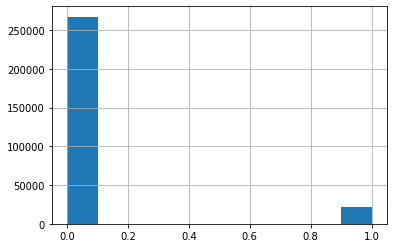

In [22]:
waterco_data_coded['Billing_Issues_1month'].hist(figsize=(6, 4))
plt.show()

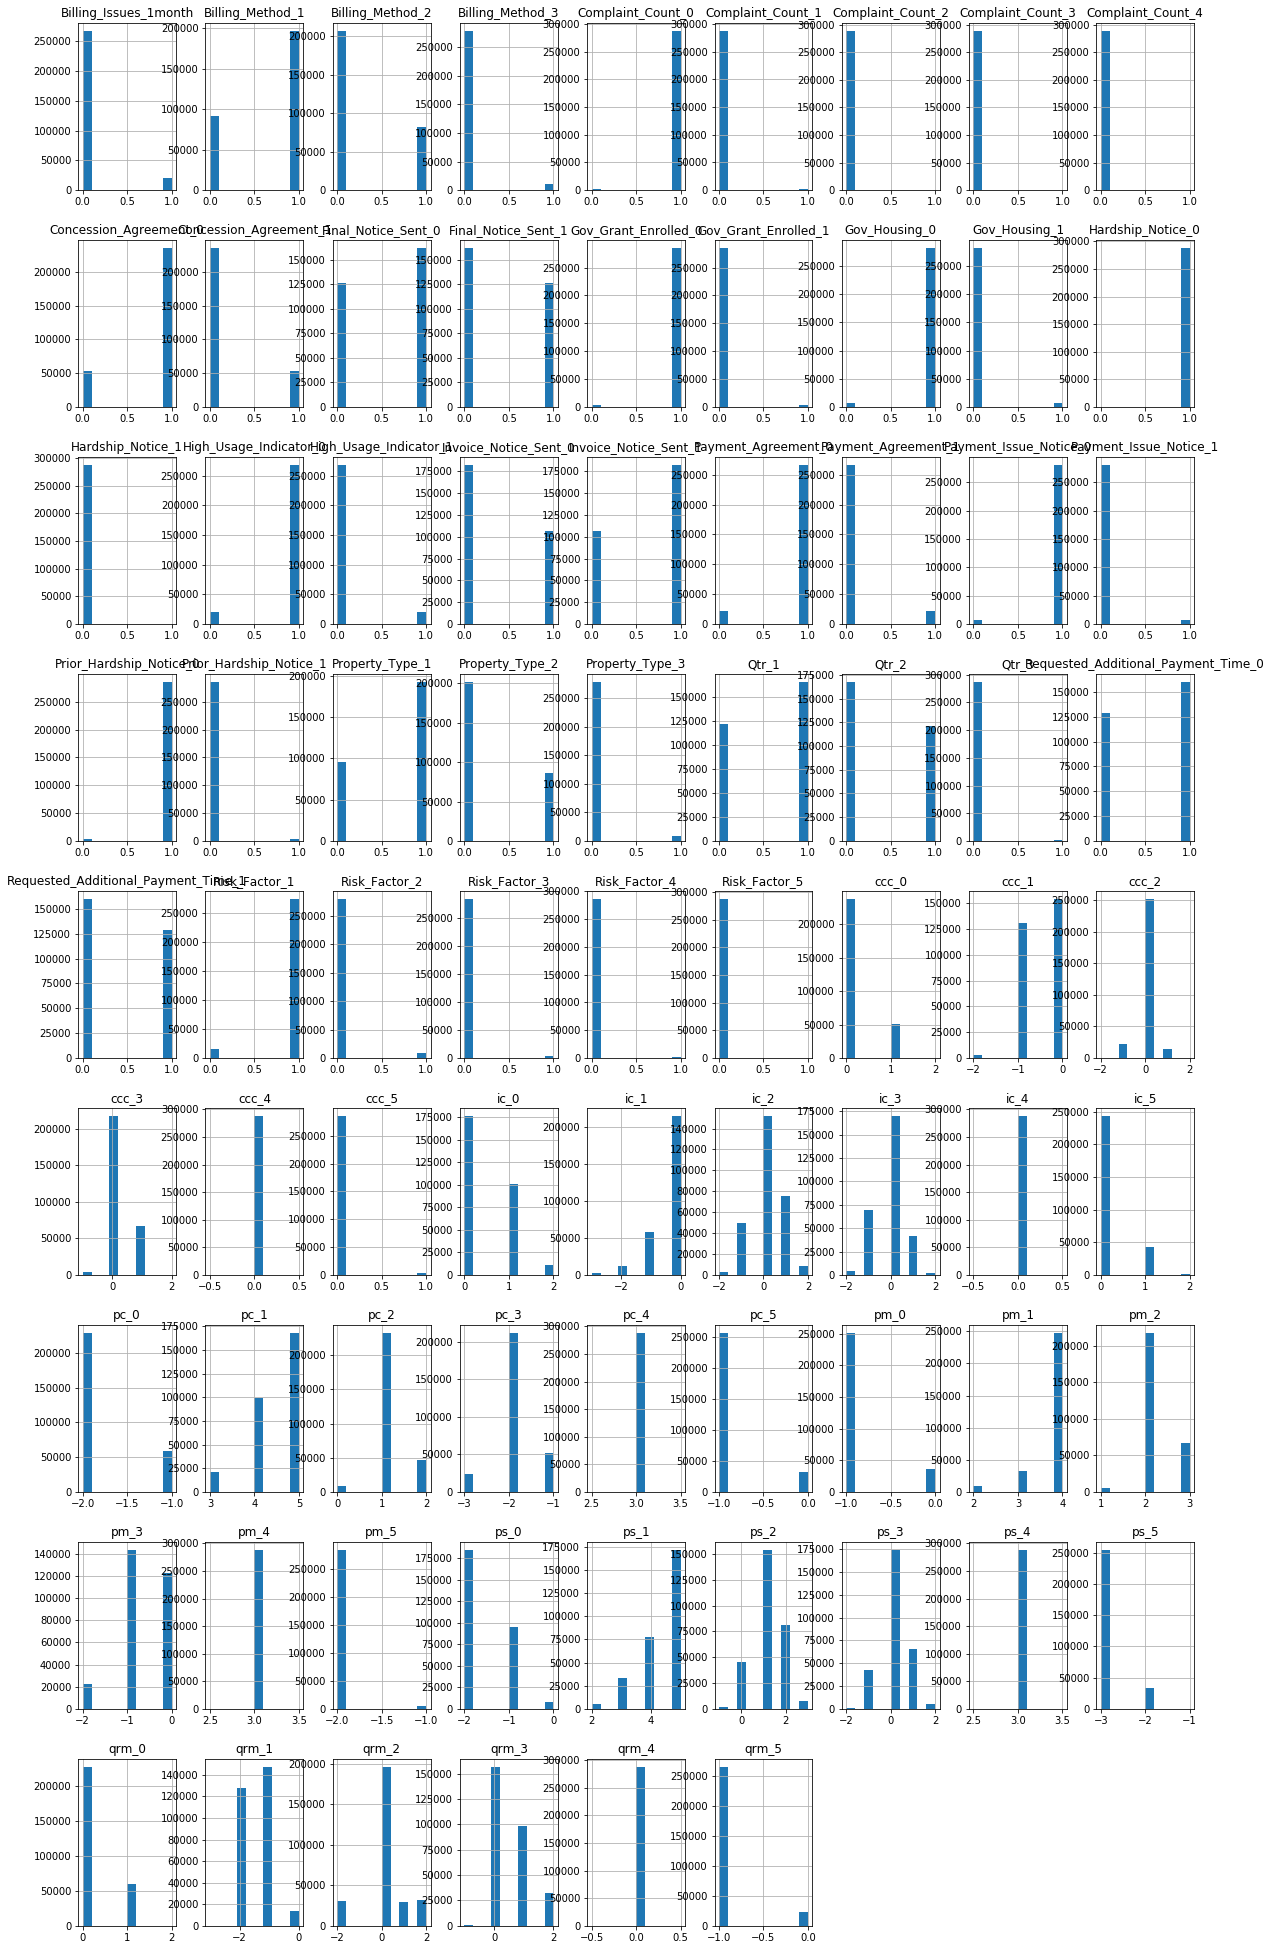

In [23]:
waterco_data_coded.hist(figsize=(20, 35))
plt.show()

Summary: the target variable is an imbalanced data (intrinsic). This will be considered during the model training

### Feature Selection:

#### Feature selection: Filter Method - Univariate selection (chi-squared)
Statistical tests can be used to select those features that have the strongest relationship with the output variable.
The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests 
to select a specific number of features.
Here chi-squared (chi²) statistical test for non-negative features to select 10 of the best features.

In [24]:
waterco_data_chi = waterco_data_coded.astype('object')

In [25]:
#Getting all the categorical columns except the target
categorical_columns = waterco_data_chi.select_dtypes(exclude = 'number').drop('Billing_Issues_1month', axis = 1).columns

In [26]:
chi2_check = []
for i in categorical_columns:
    if chi2_contingency(pd.crosstab(waterco_data_chi['Billing_Issues_1month'], waterco_data_chi[i]))[1] < 0.05:
        chi2_check.append('Reject Null Hypothesis')
    else:
        chi2_check.append('Fail to Reject Null Hypothesis')
res = pd.DataFrame(data = [categorical_columns, chi2_check]).T 
res.columns = ['Column', 'Hypothesis']

significant_features = res[res['Hypothesis'] == 'Reject Null Hypothesis']
non_significant_features = res[res['Hypothesis'] == 'Fail to Reject Null Hypothesis']
non_significant_features


,Column,Hypothesis
4,ps_4,Fail to Reject Null Hypothesis
5,ps_5,Fail to Reject Null Hypothesis
10,ccc_4,Fail to Reject Null Hypothesis
16,ic_4,Fail to Reject Null Hypothesis
22,pc_4,Fail to Reject Null Hypothesis
28,qrm_4,Fail to Reject Null Hypothesis
34,pm_4,Fail to Reject Null Hypothesis
36,Qtr_1,Fail to Reject Null Hypothesis
37,Qtr_2,Fail to Reject Null Hypothesis
49,Payment_Agreement_0,Fail to Reject Null Hypothesis


In [27]:
non_significant_features.shape

(15, 2)

In [28]:
significant_features.shape

(62, 2)

Summary: Chi square method helped to find 15 non_significant features

#### Feature selection: Wrapper method
All the possible features are fed to the model at first. We check the performance of the model and then iteratively 
remove the worst performing features one by one till the overall performance of the model comes in acceptable range.
The performance metric used here to evaluate feature performance is pvalue. 
If the pvalue is above 0.05 then we remove the feature, else we keep it.

In [29]:
#Adding constant column of ones, mandatory for sm.OLS model (Backward Elimination)
X = waterco_data_coded.drop("Billing_Issues_1month",1)
features = X.columns.tolist()
y = waterco_data_coded["Billing_Issues_1month"]          #Target Variable
X_be = sm.add_constant(X)
#Fitting sm.OLS model
model = sm.OLS(y,X_be).fit()
p_values = sm.OLS(y, X_be).fit().pvalues[1:]
max_p_value = p_values.max()
if(max_p_value >= 0.05):
    excluded_feature = p_values.idxmax()
    features.remove(excluded_feature)

    
# model.pvalues.sort_values(ascending=False).tail(25)

# features

In [51]:
print(features)

['ps_0', 'ps_1', 'ps_2', 'ps_3', 'ps_4', 'ps_5', 'ccc_0', 'ccc_1', 'ccc_2', 'ccc_3', 'ccc_4', 'ccc_5', 'ic_0', 'ic_1', 'ic_3', 'ic_4', 'ic_5', 'pc_0', 'pc_1', 'pc_2', 'pc_3', 'pc_4', 'pc_5', 'qrm_0', 'qrm_1', 'qrm_2', 'qrm_3', 'qrm_4', 'qrm_5', 'pm_0', 'pm_1', 'pm_2', 'pm_3', 'pm_4', 'pm_5', 'Qtr_1', 'Qtr_2', 'Qtr_3', 'Billing_Method_1', 'Billing_Method_2', 'Billing_Method_3', 'Risk_Factor_1', 'Risk_Factor_2', 'Risk_Factor_3', 'Risk_Factor_4', 'Risk_Factor_5', 'Hardship_Notice_0', 'Hardship_Notice_1', 'Payment_Agreement_0', 'Payment_Agreement_1', 'Concession_Agreement_0', 'Concession_Agreement_1', 'High_Usage_Indicator_0', 'High_Usage_Indicator_1', 'Invoice_Notice_Sent_0', 'Invoice_Notice_Sent_1', 'Final_Notice_Sent_0', 'Final_Notice_Sent_1', 'Payment_Issue_Notice_0', 'Payment_Issue_Notice_1', 'Requested_Additional_Payment_Time_0', 'Requested_Additional_Payment_Time_1', 'Gov_Grant_Enrolled_0', 'Gov_Grant_Enrolled_1', 'Prior_Hardship_Notice_0', 'Prior_Hardship_Notice_1', 'Complaint_Coun

#### Feature selection: Embedded method
Regularization methods are the most commonly used embedded methods which penalize a feature given a coefficient 
threshold. Here Lasso regularization is used. If the feature is irrelevant, lasso penalizes it’s coefficient 
and make it 0. Hence the features with coefficient = 0 are removed and the rest are taken.

In [30]:
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 0.000017
Best score using built-in LassoCV: 0.120413


In [72]:
print(coef.sort_values(ascending=False))

ccc_5                      0.133893
Risk_Factor_2              0.090516
pm_0                       0.048521
pm_5                       0.047825
Prior_Hardship_Notice_0    0.044061
                             ...   
Risk_Factor_5             -0.040727
High_Usage_Indicator_0    -0.043979
pm_1                      -0.049883
Hardship_Notice_0         -0.081540
Gov_Housing_0             -0.337258
Length: 77, dtype: float64


Text(0.5, 1.0, 'Feature importance using Lasso Model')

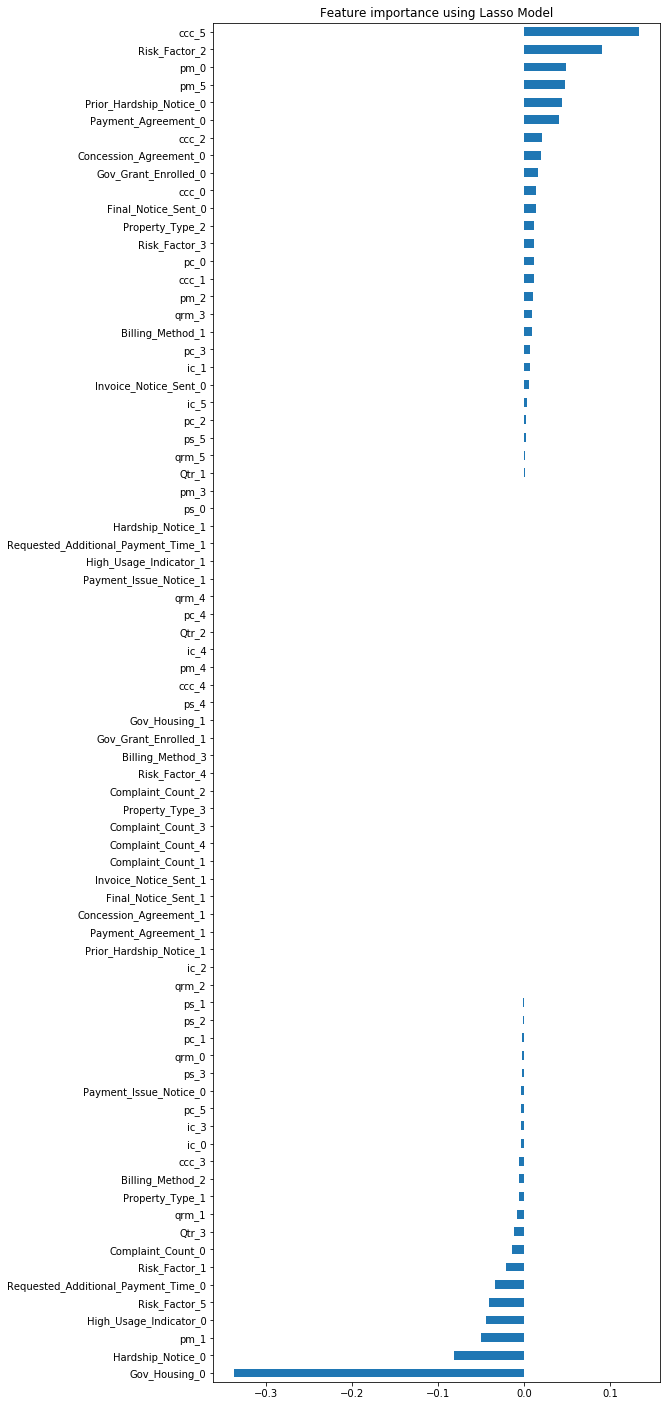

In [31]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 25.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")
# print(coef != 0)

Summary: Hardship_notice, Complain_Count, Qtr_Rain_MM, Property_Suburb, Invoice_Count, and Property_County 
are shown as least important from this analysis.

### Model training

#### Instrinsic Imballanced dataset:
extremely imballaed - approaches used to balance the data:
* downsampling
* weighted approach

#### Datasets:
the waterco_data (original dataset) will be used for baseline, the waterco_data_coded will be used for all features
after encoding and resampling, and the waterco_data_chi will be used to see the impact of feature selection 
after the chi square analysis and on encoded-resampled data.

#### Algorithms:
Logistic Regression and Decision Three ML algorithms will be used an dcompared

In [32]:
waterco_data['Billing_Issues_1month'].value_counts()

0    267094
1     21093
Name: Billing_Issues_1month, dtype: int64

In [33]:
# check the distribution
waterco_data['Billing_Issues_1month'].value_counts()/waterco_data.shape[0]

0    0.926808
1    0.073192
Name: Billing_Issues_1month, dtype: float64

### Logistic Regression

#### Logistic Regression (Default)

the originall data is compared with the one after outlier removal and the performance was similar. The dataset
with removed outliers is used in the training.

In [34]:
waterco_data.head(5)

,Billing_Issues_1month,Invoice_Count,Qtr,Billing_Method,Payment_Method,Risk_Factor,Hardship_Notice,Payment_Agreement,Concession_Agreement,High_Usage_Indicator,Invoice_Notice_Sent,Final_Notice_Sent,Payment_Issue_Notice,Requested_Additional_Payment_Time,Gov_Grant_Enrolled,Prior_Hardship_Notice,Complaint_Count,Customer_Contact_Count,Property_Type,Property_Suburb,Property_County,Gov_Housing,Qtr_Rain_MM
0,0,50,1,1,1,1,0,1,0,0,1,1,1,1,0,0,0,8,1,1,1,0,152.2
1,0,51,2,1,1,1,0,1,0,0,1,1,1,1,0,0,0,8,1,1,1,0,172.1
2,0,38,1,1,2,1,0,0,0,0,1,1,0,0,0,0,0,1,1,3,3,0,132.8
3,0,34,1,1,2,1,0,0,1,0,1,0,0,1,0,0,0,3,3,4,1,0,152.2
4,1,33,1,2,4,1,0,0,0,0,1,1,0,1,0,0,0,4,3,5,4,0,98.2


In [35]:
X_default = waterco_data.drop("Billing_Issues_1month",1)   #Feature Matrix after outlier removal
y_default = waterco_data["Billing_Issues_1month"]          #Target Variable

X_coded = waterco_data_coded.drop("Billing_Issues_1month",1)   #Feature Matrix after outlier removal
y_coded = waterco_data_coded["Billing_Issues_1month"]          #Target Variable

In [36]:
# train-test split

X_train_def, X_test_def, y_train_def, y_test_def = train_test_split(X_default, y_default, test_size=0.2,random_state=123)


X_train_coded, X_test_coded, y_train_coded, y_test_coded = train_test_split(X_coded, y_coded, test_size=0.2,random_state=123)

In [37]:
# default model (baseline) on waterco_data
lg = LogisticRegression(random_state=123, class_weight=None)
# fit it
lg.fit(X_train_def,y_train_def)
# test
y_pred_def = lg.predict(X_test_def)
y_score_def = lg.predict_proba(X_test_def)

Logit_test = metrics.average_precision_score(y_test_def, y_pred_def)
print("Logistic test score:",Logit_test)

# performance
conf_mat = confusion_matrix(y_test_def, y_pred_def)
accuracy = accuracy_score(y_test_def, y_pred_def)
score = precision_recall_fscore_support(y_test_def, y_pred_def, average='weighted')
precision, recall, fscore, k = score
print(classification_report(y_test_def, y_pred_def))
print("Accuracy:",accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F score:",fscore)
print(f'Area Under Curve: {roc_auc_score(y_test_def, y_pred_def)}')

Logistic test score: 0.20714670003072178
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     53459
           1       0.78      0.19      0.31      4179

    accuracy                           0.94     57638
   macro avg       0.86      0.59      0.64     57638
weighted avg       0.93      0.94      0.92     57638

Accuracy: 0.9374197577986745
Precision: 0.9287354326761028
Recall: 0.9374197577986745
F score: 0.9192488566984257
Area Under Curve: 0.5928121530728648


/Users/atieh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [38]:
# dataset with dummy variables
lg = LogisticRegression(random_state=123, class_weight=None)
# fit it
lg.fit(X_train_coded,y_train_coded)
# test
y_pred_coded = lg.predict(X_test_coded)
y_score_coded = lg.predict_proba(X_test_coded)

Logit_test = metrics.average_precision_score(y_test_coded, y_pred_coded)
print("Logistic test score:",Logit_test)

# performance
conf_mat = confusion_matrix(y_test_coded, y_pred_coded)
accuracy = accuracy_score(y_test_coded, y_pred_coded)
score = precision_recall_fscore_support(y_test_coded, y_pred_coded, average='weighted')
precision, recall, fscore, k = score
print(classification_report(y_test_coded, y_pred_coded))
print("Accuracy:",accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F score:",fscore)
print(f'Area Under Curve: {roc_auc_score(y_test_coded, y_pred_coded)}')

Logistic test score: 0.1984089839055091
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     53459
           1       0.82      0.17      0.28      4179

    accuracy                           0.94     57638
   macro avg       0.88      0.58      0.62     57638
weighted avg       0.93      0.94      0.92     57638

Accuracy: 0.9370380651653423
Precision: 0.9303028079562115
Recall: 0.9370380651653423
F score: 0.9171899721425771
Area Under Curve: 0.5825697352622932


/Users/atieh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Sumarry: the influence of the imbanace data is visible here. The model predicts the majority class very well but has 
problem predicting the minarity class. Downsampling below is used to remove data bias and to balance the date.

#### Downsampling:
The target variable is resampled by downsampling the majority class (Billing_Issues_1month=0) to be equal to the
minarity class (1)

In [39]:
data_majority = waterco_data_coded[waterco_data_coded.Billing_Issues_1month==0]
data_minority = waterco_data_coded[waterco_data_coded.Billing_Issues_1month==1]

data_minarity_downsampled = resample(data_majority, replace=True, n_samples=21093, random_state=123)

/Users/atieh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/atieh/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


Logistic test score: 0.6038021862674593
              precision    recall  f1-score   support

           0       0.61      0.78      0.68      4198
           1       0.70      0.52      0.59      4240

    accuracy                           0.65      8438
   macro avg       0.66      0.65      0.64      8438
weighted avg       0.66      0.65      0.64      8438

Accuracy: 0.6450580706328514
Precision: 0.6562923008767773
Recall: 0.6450580706328514
F score: 0.6390632700777389
Area Under Curve: 0.645703479644395


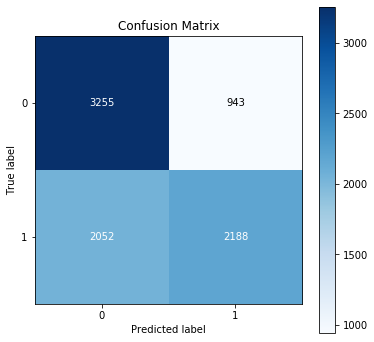

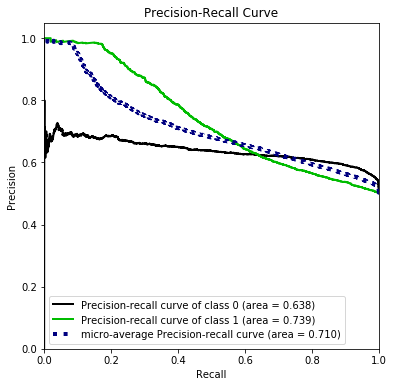

In [40]:
data_downsampled = pd.concat([data_minarity_downsampled, data_minority])
X_sampled = data_downsampled.drop("Billing_Issues_1month",1)
y_sampled = data_downsampled["Billing_Issues_1month"]

X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = train_test_split(
    X_sampled, y_sampled, test_size=0.2, random_state=0)

lg1 = LogisticRegression()
lg1.fit(X_train_sampled, y_train_sampled)
y_pred_sampled = lg1.predict(X_test_sampled)
y_score_sampled = lg1.predict_proba(X_test_sampled)

Logit_test = metrics.average_precision_score(y_test_sampled, y_pred_sampled)
print("Logistic test score:",Logit_test)
# performance
conf_mat = confusion_matrix(y_test_sampled, y_pred_sampled)
accuracy = accuracy_score(y_test_sampled, y_pred_sampled)
score = precision_recall_fscore_support(y_test_sampled, y_pred_sampled, average='weighted')
precision, recall, fscore, k = score
skplt.metrics.plot_confusion_matrix(y_test_sampled, y_pred_sampled, figsize=(6, 6))
skplt.metrics.plot_precision_recall_curve(y_test_sampled, y_score_sampled, figsize=(6, 6))
print(classification_report(y_test_sampled, y_pred_sampled))
print("Accuracy:",accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F score:",fscore)
print(f'Area Under Curve: {roc_auc_score(y_test_sampled,y_pred_sampled)}')

#### Weighted Logistic Regression:
Adding penalty and weight to the modeling is another way of solving imbalance data problem specially when the number
of items in one class is much higher than the other one. I tried using this on the original data but the model
performance was bad. I also tried to use more complex wighting methods like XGBoost but the runtime was taking long 
and thus I did not focus further on this approach. 
for simplicity, I have added the approach on the balanced data from resampling step. The model performance did not change.

In [41]:
param_grid = [{'C': [10,11,12,13,14,20],'penalty': ['l1', 'l2']}]

model = LogisticRegression()

model2 = GridSearchCV(model, param_grid,cv=5, n_jobs=-1,scoring='roc_auc', refit=True)
model2.fit(X_train_coded,y_train_coded)
print(model2.best_params_)
print(model2.best_score_)

/Users/atieh/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.68293265        nan 0.68292085        nan 0.68294821
        nan 0.68309752        nan 0.68296259        nan 0.68300409]
  category=UserWarning


{'C': 13, 'penalty': 'l2'}
0.6830975178499817


/Users/atieh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [42]:
# define model
# in the case of original data I used a class_weight of {0: 7, 1:93}
lg3 = LogisticRegression(random_state=123,C=13,fit_intercept=True, penalty='l2', class_weight = {0: 1, 1:14})
# fit it
lg3.fit(X_train_coded,y_train_coded)
# test
y_pred_coded = lg3.predict(X_test_coded)

y_score_coded = lg3.predict_proba(X_test_coded)

Logit_test = metrics.average_precision_score(y_test_coded, y_pred_coded)
print("Logistic test score:",Logit_test)
# performance
conf_mat = confusion_matrix(y_test_coded, y_pred_coded)
accuracy = accuracy_score(y_test_coded, y_pred_coded)
score = precision_recall_fscore_support(y_test_coded, y_pred_coded, average='weighted')
precision, recall, fscore, k = score
print(classification_report(y_test_coded, y_pred_coded))
print("Accuracy:",accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F score:",fscore)
print(f'Area Under Curve: {roc_auc_score(y_test_coded, y_pred_coded)}')

Logistic test score: 0.10628214995411288
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     53459
           1       0.13      0.58      0.21      4179

    accuracy                           0.69     57638
   macro avg       0.54      0.64      0.51     57638
weighted avg       0.90      0.69      0.76     57638

Accuracy: 0.6897706374266976
Precision: 0.895351300511905
Recall: 0.6897706374266976
F score: 0.7637603517252215
Area Under Curve: 0.639305962586961


/Users/atieh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#### SMOTE:
This is another resampling method. I tried different sampling_strategy values but the performance did not improve.

In [43]:
# Separate input features and target
y_s = y_coded
X_s = X_coded

# setting up testing and training sets
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_s, y_s, test_size=0.2, random_state=123)

sm = SMOTE(random_state=123, sampling_strategy=0.2)
X_train_smote, y_train_smote = sm.fit_sample(X_train_smote, y_train_smote)


In [44]:
smote = LogisticRegression().fit(X_train_smote, y_train_smote)

y_pred_smote = smote.predict(X_test_smote)

y_score_smote = smote.predict_proba(X_test_smote)

Logit_test = metrics.average_precision_score(y_test_smote, y_pred_smote)
print("Logistic test score:",Logit_test)
# performance
conf_mat = confusion_matrix(y_test_smote, y_pred_smote)
accuracy = accuracy_score(y_test_smote, y_pred_smote)
score = precision_recall_fscore_support(y_test_smote, y_pred_smote, average='weighted')
precision, recall, fscore, k = score
print(classification_report(y_test_smote, y_pred_smote))
print("Accuracy:",accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F score:",fscore)
print(f'Area Under Curve: {roc_auc_score(y_test_smote, y_pred_smote)}')

Logistic test score: 0.19461872112229836
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     53459
           1       0.77      0.18      0.29      4179

    accuracy                           0.94     57638
   macro avg       0.85      0.59      0.63     57638
weighted avg       0.93      0.94      0.92     57638

Accuracy: 0.9363614282244352
Precision: 0.9266812228673573
Recall: 0.9363614282244352
F score: 0.9173700359571478
Area Under Curve: 0.5859549278720557


/Users/atieh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Final Sumarry: The f1_score and Accuracy of the Logist Regression form resampling is about ~66% which is not a very good number
But at the same time, the features correlation with target was low and thus further feature engineering approaches should 
be investigated.
Similarly, other resampling/ensample/impabance data correction approaches should be investigated as by using the current downsampling approach,
many data is removed which is not a preferable approach. I did not try the upsampling due to the extreme margin between
the two class.

#### Feature selection included: chi-square

In [100]:
non_sig_features = ['ps_5', 'qrm_4', 'ic_4', 'Property_Type_3', 'Payment_Agreement_0', 'pc_4', 'pm_4', 'Complaint_Count_3',
                    'Complaint_Count_2','Complaint_Count_4', 'ps_4', 'Payment_Agreement_1', 'Qtr_1', 'Qtr_2', 'ccc_4']

water_data_coded_sig = waterco_data_coded.drop(non_sig_features, axis = 1)

In [101]:

data_majority = water_data_coded_sig[waterco_data_coded.Billing_Issues_1month==0]
data_minority = water_data_coded_sig[waterco_data_coded.Billing_Issues_1month==1]

data_minarity_downsampled = resample(data_majority, replace=True, n_samples=21093, random_state=123).reset_index()
data_minarity_downsampled = data_minarity_downsampled.drop('index', axis = 1)
data_downsampled = pd.concat([data_minarity_downsampled, data_minority]).reset_index()
data_downsampled = data_downsampled.drop('index', axis = 1)

In [102]:
X_sampled = data_downsampled.drop("Billing_Issues_1month",1)
y_sampled = data_downsampled["Billing_Issues_1month"]

X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = train_test_split(
    X_sampled, y_sampled, test_size=0.2, random_state=0)

lg1 = LogisticRegression()
lg1.fit(X_train_sampled, y_train_sampled)
y_pred_sampled = lg1.predict(X_test_sampled)
y_score_sampled = lg1.predict_proba(X_test_sampled)

Logit_test = metrics.average_precision_score(y_test_sampled, y_pred_sampled)
print("Logistic test score:",Logit_test)
# performance
conf_mat = confusion_matrix(y_test_sampled, y_pred_sampled)
accuracy = accuracy_score(y_test_sampled, y_pred_sampled)
score = precision_recall_fscore_support(y_test_sampled, y_pred_sampled, average='weighted')
precision, recall, fscore, k = score

print(classification_report(y_test_sampled, y_pred_sampled))
print("Accuracy:",accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F score:",fscore)
print(f'Area Under Curve: {roc_auc_score(y_test_sampled,y_pred_sampled)}')

Logistic test score: 0.603364200409893
              precision    recall  f1-score   support

           0       0.61      0.77      0.68      4198
           1       0.70      0.52      0.60      4240

    accuracy                           0.64      8438
   macro avg       0.66      0.65      0.64      8438
weighted avg       0.66      0.64      0.64      8438

Accuracy: 0.6449395591372363
Precision: 0.6554356792431824
Recall: 0.6449395591372363
F score: 0.6393284000764705
Area Under Curve: 0.6455643185883664


/Users/atieh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [106]:
# lg1.fit(X / np.std(X_sampled, 0), y_sampled)
print(lg1.coef_)


[[-0.01034315 -0.02591978 -0.01929763 -0.0308949   0.15955049  0.22510244
   0.14504077 -0.16070785  1.23087692 -0.07690233  0.1178407  -0.02975318
  -0.01879223  0.0585756   0.09774683  0.0065105   0.0244932   0.03743487
  -0.09835974  0.03350808 -0.11345037 -0.04269125  0.08952796  0.06016453
   0.35834785 -0.56075182  0.10544173 -0.06640347  0.48326042 -0.54866642
   0.32132859  0.1712798   0.18850701  0.06738395  0.45659867  0.41785083
   0.31277599 -0.57349403 -0.19819583  0.87931124  0.39986679  0.28124862
   0.20315221  0.4779632   0.3652167   0.31589871  0.44931967  0.23179574
   0.2625542   0.41856121  0.1180445   0.56307091  0.2865734   0.39454201
   0.56867852  0.11243689 -0.03436908  0.36826116 -0.08605182  0.13358466
  -0.44800197  1.12911738]]


In [135]:
df1 = pd.DataFrame(X_sampled.columns)

coefficients = pd.concat([df1.rename(columns={0:'features'}),pd.DataFrame(np.transpose(lg1.coef_)).rename(columns={0:'coef'})], axis = 1)

In [141]:
coefficients.sort_values('coef',ascending=False).head(10)

,features,coef
8,ccc_5,1.230877
61,Gov_Housing_1,1.129117
39,Hardship_Notice_1,0.879311
54,Prior_Hardship_Notice_0,0.568679
51,Requested_Additional_Payment_Time_1,0.563071
28,pm_5,0.483260
43,High_Usage_Indicator_1,0.477963
34,Risk_Factor_2,0.456599
46,Final_Notice_Sent_0,0.449320
49,Payment_Issue_Notice_1,0.418561


#### Feature selection - wrapper:

In [97]:
water_data_coded_sig = waterco_data_coded[['ps_0', 'ps_1', 'ps_2', 'ps_3', 'ps_4', 'ps_5', 'ccc_0', 'ccc_1', 'ccc_2', 'ccc_3', 'ccc_4', 'ccc_5', 'ic_0', 
 'ic_1', 'ic_3', 'ic_4', 'ic_5', 'pc_0', 'pc_1', 'pc_2', 'pc_3', 'pc_4', 'pc_5', 'qrm_0', 'qrm_1', 'qrm_2', 
 'qrm_3', 'qrm_4', 'qrm_5', 'pm_0', 'pm_1', 'pm_2', 'pm_3', 'pm_4', 'pm_5', 'Qtr_1', 'Qtr_2', 'Qtr_3', 
 'Billing_Method_1', 'Billing_Method_2', 'Billing_Method_3', 'Risk_Factor_1', 'Risk_Factor_2', 'Risk_Factor_3', 
 'Risk_Factor_4', 'Risk_Factor_5', 'Hardship_Notice_0', 'Hardship_Notice_1', 'Payment_Agreement_0', 
 'Payment_Agreement_1', 'Concession_Agreement_0', 'Concession_Agreement_1', 'High_Usage_Indicator_0', 
 'High_Usage_Indicator_1', 'Invoice_Notice_Sent_0', 'Invoice_Notice_Sent_1', 'Final_Notice_Sent_0', 
 'Final_Notice_Sent_1', 'Payment_Issue_Notice_0', 'Payment_Issue_Notice_1', 'Requested_Additional_Payment_Time_0',
 'Requested_Additional_Payment_Time_1', 'Gov_Grant_Enrolled_0', 'Gov_Grant_Enrolled_1', 'Prior_Hardship_Notice_0', 
 'Prior_Hardship_Notice_1', 'Complaint_Count_0', 'Complaint_Count_1', 'Complaint_Count_2', 'Complaint_Count_3', 
 'Complaint_Count_4', 'Property_Type_1', 'Property_Type_2', 'Property_Type_3', 'Gov_Housing_0', 'Gov_Housing_1',
                                          "Billing_Issues_1month"]]


# wrapper_columns =['ic_5', 'ps_2', 'ps_3', 'ccc_3', 'ic_0', 'ic_3', 'qrm_1', 'pc_3', 'ic_1', 'pc_0', 'pm_2', 'ccc_1',
#                   'ccc_0', 'qrm_3', 'pm_5', 'ccc_2', 'ccc_5', 'pm_0','pm_1', "Billing_Issues_1month"]


In [98]:
data_majority = water_data_coded_sig[waterco_data_coded.Billing_Issues_1month==0]
data_minority = water_data_coded_sig[waterco_data_coded.Billing_Issues_1month==1]

data_minarity_downsampled = resample(data_majority, replace=True, n_samples=21093, random_state=123).reset_index()
data_minarity_downsampled = data_minarity_downsampled.drop('index', axis = 1)
data_downsampled = pd.concat([data_minarity_downsampled, data_minority]).reset_index()
data_downsampled = data_downsampled.drop('index', axis = 1)

In [99]:
X_sampled = data_downsampled.drop("Billing_Issues_1month",1)
y_sampled = data_downsampled["Billing_Issues_1month"]

X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = train_test_split(
    X_sampled, y_sampled, test_size=0.2, random_state=0)

lg1 = LogisticRegression()
lg1.fit(X_train_sampled, y_train_sampled)
y_pred_sampled = lg1.predict(X_test_sampled)
y_score_sampled = lg1.predict_proba(X_test_sampled)

Logit_test = metrics.average_precision_score(y_test_sampled, y_pred_sampled)
print("Logistic test score:",Logit_test)
# performance
conf_mat = confusion_matrix(y_test_sampled, y_pred_sampled)
accuracy = accuracy_score(y_test_sampled, y_pred_sampled)
score = precision_recall_fscore_support(y_test_sampled, y_pred_sampled, average='weighted')
precision, recall, fscore, k = score

print(classification_report(y_test_sampled, y_pred_sampled))
print("Accuracy:",accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F score:",fscore)
print(f'Area Under Curve: {roc_auc_score(y_test_sampled,y_pred_sampled)}')

Logistic test score: 0.6028239619504981
              precision    recall  f1-score   support

           0       0.61      0.78      0.68      4198
           1       0.70      0.51      0.59      4240

    accuracy                           0.64      8438
   macro avg       0.66      0.64      0.64      8438
weighted avg       0.66      0.64      0.64      8438

Accuracy: 0.6437544441810855
Precision: 0.6552992546365093
Recall: 0.6437544441810855
F score: 0.6375219268478257
Area Under Curve: 0.6444110290614578


/Users/atieh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#### Feature Selection Embedded

In [89]:
water_data_coded_sig = waterco_data_coded[['ccc_5', 'Risk_Factor_2', 'pm_0', 'pm_5','Prior_Hardship_Notice_0',
                                           'Gov_Housing_0', 'Hardship_Notice_0', 'pm_1', 'High_Usage_Indicator_0',
                                           'Risk_Factor_5',"Billing_Issues_1month"]]

In [91]:
data_majority = water_data_coded_sig[waterco_data_coded.Billing_Issues_1month==0]
data_minority = water_data_coded_sig[waterco_data_coded.Billing_Issues_1month==1]

data_minarity_downsampled = resample(data_majority, replace=True, n_samples=21093, random_state=123).reset_index()
data_minarity_downsampled = data_minarity_downsampled.drop('index', axis = 1)
data_downsampled = pd.concat([data_minarity_downsampled, data_minority]).reset_index()
data_downsampled = data_downsampled.drop('index', axis = 1)

In [92]:
X_sampled = data_downsampled.drop("Billing_Issues_1month",1)
y_sampled = data_downsampled["Billing_Issues_1month"]

X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = train_test_split(
    X_sampled, y_sampled, test_size=0.2, random_state=0)

lg1 = LogisticRegression()
lg1.fit(X_train_sampled, y_train_sampled)
y_pred_sampled = lg1.predict(X_test_sampled)
y_score_sampled = lg1.predict_proba(X_test_sampled)

Logit_test = metrics.average_precision_score(y_test_sampled, y_pred_sampled)
print("Logistic test score:",Logit_test)
# performance
conf_mat = confusion_matrix(y_test_sampled, y_pred_sampled)
accuracy = accuracy_score(y_test_sampled, y_pred_sampled)
score = precision_recall_fscore_support(y_test_sampled, y_pred_sampled, average='weighted')
precision, recall, fscore, k = score

print(classification_report(y_test_sampled, y_pred_sampled))
print("Accuracy:",accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F score:",fscore)
print(f'Area Under Curve: {roc_auc_score(y_test_sampled,y_pred_sampled)}')

Logistic test score: 0.576899371767519
              precision    recall  f1-score   support

           0       0.57      0.83      0.68      4198
           1       0.69      0.39      0.50      4240

    accuracy                           0.61      8438
   macro avg       0.63      0.61      0.59      8438
weighted avg       0.63      0.61      0.59      8438

Accuracy: 0.6065418345579521
Precision: 0.6338057141242162
Recall: 0.6065418345579521
F score: 0.5865408328896157
Area Under Curve: 0.6076399251215763


#### Decision Tree

In [142]:
dt = DecisionTreeClassifier(criterion='gini')
dt.fit(X_train_sampled, y_train_sampled)
y_score_sampled = dt.predict_proba(X_test_sampled)
y_pred_sampled = dt.predict(X_test_sampled)
# performance
conf_mat = confusion_matrix(y_test_sampled, y_pred_sampled)
accuracy = accuracy_score(y_test_sampled, y_pred_sampled)
score = precision_recall_fscore_support(y_test_sampled, y_pred_sampled, average='weighted')
precision, recall, fscore, k = score
print(classification_report(y_test_sampled, y_pred_sampled))
print("Accuracy:",accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F score:",fscore)
print(f'Area Under Curve: {roc_auc_score(y_test_sampled,y_pred_sampled)}')

              precision    recall  f1-score   support

           0       0.62      0.63      0.62      4198
           1       0.63      0.62      0.62      4240

    accuracy                           0.62      8438
   macro avg       0.62      0.62      0.62      8438
weighted avg       0.62      0.62      0.62      8438

Accuracy: 0.6227779094572173
Precision: 0.6228038191294507
Recall: 0.6227779094572173
F score: 0.622778889601377
Area Under Curve: 0.6227903898532094


In [143]:
from sklearn.tree import export_text
tree_rules = export_text(dt, feature_names=list(X_train_sampled.columns))

In [145]:
print(tree_rules)

|--- Gov_Housing_0 <= 0.50
|   |--- Concession_Agreement_0 <= 0.50
|   |   |--- ccc_0 <= 0.50
|   |   |   |--- ccc_1 <= -1.50
|   |   |   |   |--- Risk_Factor_4 <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Risk_Factor_4 >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- ccc_1 >  -1.50
|   |   |   |   |--- pm_1 <= 2.50
|   |   |   |   |   |--- pc_3 <= -2.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- pc_3 >  -2.50
|   |   |   |   |   |   |--- Prior_Hardship_Notice_1 <= 0.50
|   |   |   |   |   |   |   |--- ps_2 <= 1.50
|   |   |   |   |   |   |   |   |--- Billing_Method_2 <= 0.50
|   |   |   |   |   |   |   |   |   |--- qrm_3 <= 1.50
|   |   |   |   |   |   |   |   |   |   |--- qrm_1 <= -0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |   |--- qrm_1 >  -0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- qrm_3 >  1.50
|   

#### Other methods

Other methods such as SVM, KNN, Random Forest, and Neural Network could be used to compare the performance.